# Day 3: Optimal timetables

### Problem:

Hi, I'm SalvadOR, responsible for creating a school timetable to organize classes, teachers, and rooms for an upcoming semester.

We have some strict requirements to meet. This is a very hard problem we face every year, and I need your help to design an optimal timetable.

Here's the situation:

- There are 4 classes, each requiring specific teaching sessions.
- There are 4 teachers, and each teacher has assigned subjects to teach.
- There are 4 rooms, and only one class can occupy a room during any given period.
- The timetable spans 30 periods, and we must ensure that all requirements are met without any conflicts or overlaps.

I desperately need a timetable that satisfies all requirements (each class meets with the right teacher in the right room the required number of times), avoiding any type of clashes such as double-booking a teacher, room, or class during the same period.

We say a timetable is optimized when it minimizes idle periods and maximizes resource utilization (teachers and rooms).

Can you help me solve this problem?

In instance.txt we can find an instance of the problem.

### Solution:

The aim of this problem is to minimize idle periods and maximize resource utilization (teachers and rooms). Therefore, the variables for our problem will be $x_{c,t,r,p}$ which will be binary and will be 1 if class $c$ is taught by teacher $t$ in room $r$ during period $p$, $0$ otherwise. We will also have some constraints that indicates:
- No teacher, class, or room can be booked for more than one session at the same time.
- Each requirement must be met.
- Avoid idle periods for teachers and rooms.

So the mathematical formulation for this problem is the following,

$$
\begin{align*}
\text{maximize} & \sum_{c\in\text{Classes}}\sum_{t\in\text{Teachers}}\sum_{r\in\text{Rooms}}\sum_{p\in\text{Periods}} x_{c,t,r,p}\\
\text{subject to} & \sum_{c\in\text{Classes}}\sum_{t\in\text{Teachers}} x_{c,t,r,p} \leq 1 \quad \forall r,p\\
& \sum_{c\in\text{Classes}}\sum_{r\in\text{Rooms}} x_{c,t,r,p} \leq 1 \quad \forall t,p\\
& \sum_{t\in\text{Teachers}}\sum_{r\in\text{Rooms}} x_{c,t,r,p} \leq 1 \quad \forall c,p\\
& \sum_{p\in\text{Periods}} x_{c,t,r,p} = R_{c,t,r} \quad \forall c,t,r \\ 
& x_{ij} \in\lbrace 0,1\rbrace \quad \forall c,t,r,p
\end{align*}
$$

where $R_{c,t,r}$ correspond the requirement of the class $c$, teacher $t$ and room $r$.

Therefore, once the problem is formulated, the next step is to solve it using Pyomo for the requirement matrix $R$ available in `instance_req.txt`.

In [8]:
N_TEACHERS = 4
N_SUBJECTS = 20
N_CLASSES = 4
N_ROOMS = 4
N_REQUIREMENTS = 120
N_DAYPERIODS = 6
N_DAYS = 5
N_PERIODS = N_DAYPERIODS * N_DAYS

In [ ]:
import numpy as np

file_path = "instance_req.txt"

cost_matrix = []
with open(file_path, 'r') as file:
    lines = file.readlines()

requirement_matrix = np.zeros((N_CLASSES, N_TEACHERS, N_ROOMS), dtype=int)
# Extract the requirement matrix per room
for r in range(N_ROOMS):
    start_idx = 30+r*4          # Start index for the current task row

    for c in range(N_CLASSES):
        row = list(map(int, " ".join(lines[start_idx+c]).split()))
        requirement_matrix[c,:,r] = row
    

# Check the matrix
print(requirement_matrix)

(4, 4, 4)
[[[2 2 2 3]
  [2 5 1 1]
  [1 1 1 2]
  [2 2 2 1]]

 [[1 0 0 1]
  [1 4 0 4]
  [1 3 5 1]
  [2 2 1 4]]

 [[1 1 2 3]
  [1 2 1 3]
  [1 1 4 2]
  [6 0 1 1]]

 [[2 2 6 2]
  [2 2 1 0]
  [3 1 2 1]
  [2 2 1 1]]]


In [17]:
from pyomo.environ import *

# Initialize the model
model = ConcreteModel()

# Sets
model.C = RangeSet(N_CLASSES)
model.T = RangeSet(N_TEACHERS)
model.R = RangeSet(N_ROOMS)
model.P = RangeSet(N_PERIODS)

### Variables
model.x = Var(model.C, model.T, model.R, model.P, domain=Binary)

# Requirement as parameter in Pyomo
def requirements_param(model, c, t, r):
    return requirement_matrix[c-1, t-1, r-1]  # Adjust for 0-based indexing in Python
model.Requirements = Param(model.C, model.T, model.R, initialize=requirements_param)

### Constraint
# Room clashes: A room can host at most one class in a given period
def room_clash_rule(model, r, p):
    return sum(model.x[c, t, r, p] for c in model.C for t in model.T) <= 1
model.RoomClash = Constraint(model.R, model.P, rule=room_clash_rule)

# Teacher clashes: A teacher can teach only one class in a given period
def teacher_clash_rule(model, t, p):
    return sum(model.x[c, t, r, p] for c in model.C for r in model.R) <= 1
model.TeacherClash = Constraint(model.T, model.P, rule=teacher_clash_rule)

# Class clashes: A class can attend only one session at a time
def class_clash_rule(model, c, p):
    return sum(model.x[c, t, r, p] for t in model.T for r in model.R) <= 1
model.ClassClash = Constraint(model.C, model.P, rule=class_clash_rule)

# Fulfill requirements: Each class-teacher-room combination must meet its required number of sessions
def requirements_rule(model, c, t, r):
    return sum(model.x[c, t, r, p] for p in model.P) == model.Requirements[c, t, r]
model.RequirementsConstraint = Constraint(model.C, model.T, model.R, rule=requirements_rule)


# Objective
# Minimize idle periods
def objective_rule(model):
    return sum(model.x[c, t, r, p] for c in model.C for t in model.T for r in model.R for p in model.P)
model.Objective = Objective(rule=objective_rule, sense=maximize)


# Solve the model
solver = SolverFactory('glpk')
result = solver.solve(model)

# Check and output results
if result.solver.status == 'ok' and result.solver.termination_condition == 'optimal':
    print("Optimal solution found.")
    timetable = []
    for c in model.C:
        for t in model.T:
            for r in model.R:
                for p in model.P:
                    if model.x[c, t, r, p].value == 1:
                        timetable.append((c, t, r, p))
    print("Timetable:", timetable)
else:
    print("No optimal solution found.")

Optimal solution found.
Timetable: [(1, 1, 1, 16), (1, 1, 1, 23), (1, 1, 2, 6), (1, 1, 2, 10), (1, 1, 3, 28), (1, 1, 3, 29), (1, 1, 4, 5), (1, 1, 4, 26), (1, 1, 4, 30), (1, 2, 1, 12), (1, 2, 1, 17), (1, 2, 2, 2), (1, 2, 2, 7), (1, 2, 2, 21), (1, 2, 2, 24), (1, 2, 2, 25), (1, 2, 3, 1), (1, 2, 4, 4), (1, 3, 1, 15), (1, 3, 2, 18), (1, 3, 3, 9), (1, 3, 4, 3), (1, 3, 4, 20), (1, 4, 1, 8), (1, 4, 1, 27), (1, 4, 2, 11), (1, 4, 2, 19), (1, 4, 3, 14), (1, 4, 3, 22), (1, 4, 4, 13), (2, 1, 1, 24), (2, 1, 4, 25), (2, 2, 1, 11), (2, 2, 2, 3), (2, 2, 2, 13), (2, 2, 2, 20), (2, 2, 2, 27), (2, 2, 4, 9), (2, 2, 4, 10), (2, 2, 4, 15), (2, 2, 4, 22), (2, 3, 1, 2), (2, 3, 2, 5), (2, 3, 2, 14), (2, 3, 2, 28), (2, 3, 3, 6), (2, 3, 3, 8), (2, 3, 3, 17), (2, 3, 3, 23), (2, 3, 3, 30), (2, 3, 4, 19), (2, 4, 1, 7), (2, 4, 1, 29), (2, 4, 2, 4), (2, 4, 2, 26), (2, 4, 3, 12), (2, 4, 4, 1), (2, 4, 4, 16), (2, 4, 4, 18), (2, 4, 4, 21), (3, 1, 1, 1), (3, 1, 2, 22), (3, 1, 3, 4), (3, 1, 3, 18), (3, 1, 4, 11), (3, 1, 4,

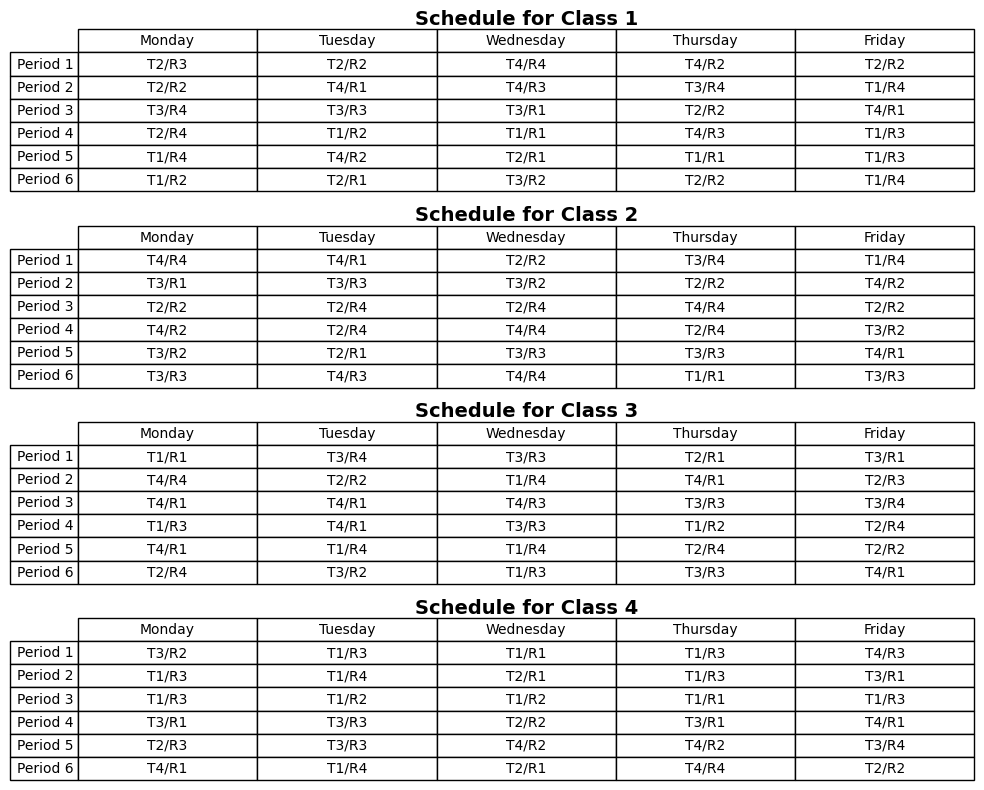

In [33]:
import matplotlib.pyplot as plt

# Initialize the schedule grid: 5 days x 6 periods
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
periods = [f'Period {i+1}' for i in range(6)]
# Create a schedule grid for each class
schedules = {class_: [['' for _ in range(5)] for _ in range(6)] for class_ in range(1, 5)}

# Populate the schedule for each class
for (class_, teacher, room, period) in timetable:
    day_idx = (period - 1) // 6  # Determine the day (0-indexed)
    period_idx = (period - 1) % 6  # Determine the period within the day (0-indexed)
    if day_idx < 5:  # Ensure within bounds of 5 days
        schedules[class_][period_idx][day_idx] = f'T{teacher}/R{room}'

# Plot schedules
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 2x2 grid for 4 classes
axes = axes.flatten()

for i, (class_, schedule) in enumerate(schedules.items()):
    ax = axes[i]
    
    # Create table
    table = ax.table(cellText=schedule, colLabels=days, rowLabels=periods, loc='center', cellLoc='center')
    ax.axis('off')  # Hide axes
    
    # Format table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    
    # Set title
    ax.set_title(f"Schedule for Class {class_}", fontsize=14,fontweight="bold")

plt.tight_layout()
plt.show()